Enron Corporation was an American energy, commodities, and services company, which was formed in 1985 by, Kenneth Lay. Enron Corporation filed for bankruptcy on December 2001. Enron case is famous for being the largest bankruptcy reorganization in American history the biggest audit failure at that time. <br>
In this project, we are asked to use the Enron email data and identify employees who may have committed fraud and were involved in the Enron scam (AKA Persons of Interest). The Person of Interest (POI) is defined as “individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity”<br>


In [ ]:
import pprint
import sys
import pickle
import pandas as pd
import numpy as np
from time import time
from tester import dump_classifier_and_data

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2

import pylab as pl
from feature_format import featureFormat
from feature_format import targetFeatureSplit

import matplotlib.pyplot as plt

In [ ]:
# %load poi_id.py
#!/usr/bin/python
sys.path.append("../tools/")

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [ ]:
pprint.pprint (data_dict.keys())
print ("There are ", len(data_dict.keys()), " executives in Enron Dataset.")


## Task 1: Select what features you'll use.
features_list is a list of strings, each of which is a feature name.<br>
The first feature must be "poi".<br>
You will need to use more features

In [ ]:
### Task 1: Select what features you'll use.

features_list = ['poi',
                 'salary',
                 'deferral_payments',
                 'total_payments',
                 'loan_advances',
                 'bonus',
                 'restricted_stock_deferred',
                 'bonus_salary_R',
                 'restricted_stock_deferred',
                 'deferred_income',
                 'total_stock_value',
                 'expenses',
                 'exercised_stock_options',
                 'other',
                 'long_term_incentive',
                 'restricted_stock',
                 'director_fees',
                 'to_messages',
                 'from_poi_to_this_person',
                 'from_poi_to_this_person_Percent',                 
                 'from_messages',
                 'from_this_person_to_poi',
                 'from_this_person_to_poi_percent',
                 'shared_receipt_with_poi']


## Task 2: Remove outliers
based on mini-project in outlier lessons, i know there is a key "Total", which holds the total value for all other values. <br>
Another one is the key "THE TRAVEL AGENCY IN THE PARK".<br>
I'm going to exclude both of them



In [2]:
pprint.pprint (data_dict["TOTAL"], width=1)
pprint.pprint (data_dict["THE TRAVEL AGENCY IN THE PARK"])

NameError: name 'data_dict' is not defined

In [3]:
data_dict.pop("TOTAL")
data_dict.pop("THE TRAVEL AGENCY IN THE PARK")

NameError: name 'data_dict' is not defined

# Task 3: Create new feature(s)
Store to my_dataset for easy export below.

In [4]:
for key, value in data_dict.iteritems():
    if value['bonus'] == "NaN" or value['salary'] == "Nan":
        value['bonus_salary_R'] = "NaN"
    else:
        value['bonus_salary_R'] = float(value['bonus']) / float(value['salary'])

for key, value in data_dict.iteritems():
    if value["from_this_person_to_poi"] == "NaN" or value["to_messages"] == "Nan":
        value['from_this_person_to_poi_percent'] = "NaN"
    else:
        value['from_this_person_to_poi_percent'] = float(value['from_this_person_to_poi'])*100 / float(value['to_messages'])

for key, value in data_dict.iteritems():
    if value["from_poi_to_this_person"] == "NaN" or value["to_messages"] == "Nan":
        value['from_poi_to_this_person_Percent'] = "NaN"
    else:
        value['from_poi_to_this_person_Percent'] = float(value['from_poi_to_this_person'])*100 / float(value['to_messages'])

NameError: name 'data_dict' is not defined

In [5]:
my_dataset = data_dict
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

NameError: name 'data_dict' is not defined

In [6]:
df = pd.DataFrame.from_dict(my_dataset, orient = 'index')
df = df[features_list]
df = df.replace('NaN', np.nan)
df.info()

NameError: name 'my_dataset' is not defined

# Task 4: Try a varity of classifiers
Please name your classifier clf for easy export below.
Note that if you want to do PCA or other multi-stage operations,
you'll need to use Pipelines. For more info:
http://scikit-learn.org/stable/modules/pipeline.html

In [34]:
# Provided to give you a starting point. Try a variety of classifiers.

data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,  test_size=0.3, random_state=42)


# Data Prep

## Feature Scaling 

In [35]:
#minmax scaler
scaler = MinMaxScaler()
scaled_feature_train = scaler.fit_transform(features_train)
scaled_feature_test = scaler.fit_transform(features_test)

# Algorithms

## Grid Search Function

In [12]:

def GridSearch (classifier, score_type, name):
    pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', classifier)
    ])
    N_FEATURES_OPTIONS = [5,10,15,20]
    param_grid = [
        {
            'reduce_dim': [PCA(iterated_power=7, random_state=42)],
            'reduce_dim__n_components': N_FEATURES_OPTIONS
        },
        {
            'reduce_dim': [SelectKBest(chi2)],
            'reduce_dim__k': N_FEATURES_OPTIONS
        },
    ]
    reducer_labels = ['PCA',  'KBest(chi2)']
    grid = GridSearchCV(pipe, cv=5, param_grid=param_grid,  scoring = score_type)
    grid.fit(scaled_feature_train, labels_train)
    clf_grid = grid.best_estimator_
    print (grid.best_params_)
    mean_scores = np.array(grid.cv_results_['mean_test_score'])
    
    mean_scores = mean_scores.reshape(1, -1, len(N_FEATURES_OPTIONS))
    mean_scores = mean_scores.max(axis=0)
    print (mean_scores)

    bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
                   (len(reducer_labels) + 1) + .5)

    plt.figure()
    COLORS = ['g', 'r']
    for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
        plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

    plt.title("PCA vs. KBest")
    plt.xlabel('Number of features')
    plt.xticks(bar_offsets + len(reducer_labels)/3, N_FEATURES_OPTIONS)
    plt.ylabel(name)
    plt.ylim((0, 1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return plt.show()




## Naive Bayes


/Users/Haleh/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'reduce_dim': SelectKBest(k=20, score_func=<function chi2 at 0x115c9da28>), 'reduce_dim__k': 20}
[[ 0.   0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.2]]


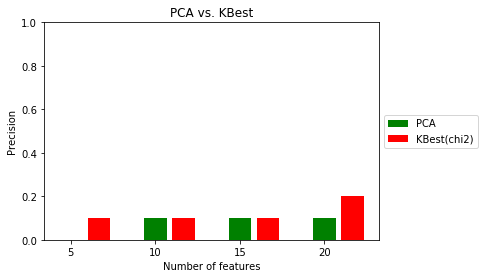

{'reduce_dim': PCA(copy=True, iterated_power=7, n_components=10, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 10}
[[ 0.   0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1]]


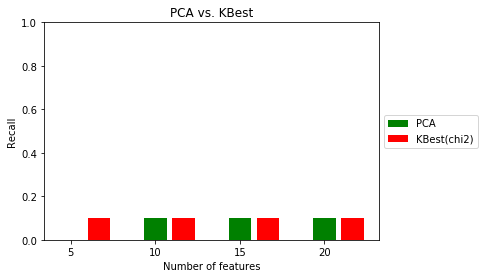

In [13]:
#Naive Bayes
classifier =LinearSVC()
GridSearch (classifier, 'precision', 'Accuracy')
GridSearch (classifier, 'precision', 'Precision')
GridSearch (classifier, 'recall', 'Recall')

## Support Vector Machine (SVM)


{'reduce_dim': PCA(copy=True, iterated_power=7, n_components=10, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 10}
[[ 0.   0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1]]


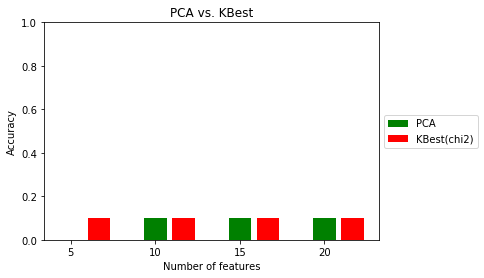

None
{'reduce_dim': PCA(copy=True, iterated_power=7, n_components=10, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 10}
[[ 0.   0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1]]


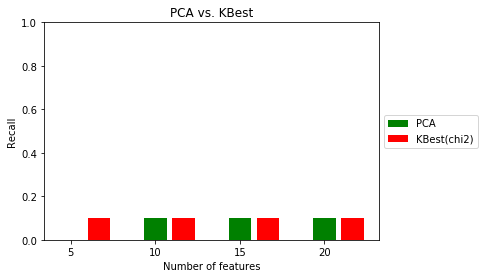

None
{'reduce_dim': SelectKBest(k=20, score_func=<function chi2 at 0x115c9da28>), 'reduce_dim__k': 20}
[[ 0.   0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.2]]


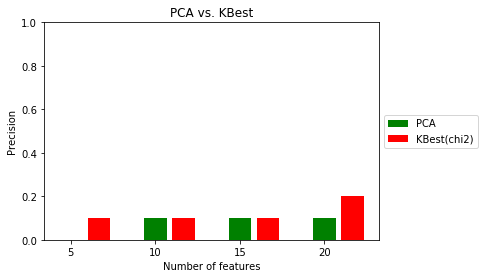

None


In [14]:
classifier = LinearSVC()

print (GridSearch (classifier,'recall',  'Accuracy'))
print (GridSearch (classifier,'recall',  'Recall'))
print (GridSearch (classifier,'precision', 'Precision'))


## Decision Trees

{'reduce_dim': PCA(copy=True, iterated_power=7, n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 20}
[[ 0.1    0.17   0.2    0.495]
 [ 0.265  0.17   0.2    0.435]]


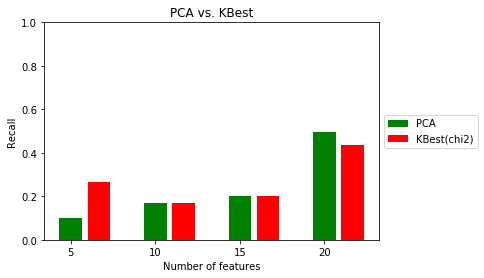

None
{'reduce_dim': SelectKBest(k=20, score_func=<function chi2 at 0x115c9da28>), 'reduce_dim__k': 20}
[[ 0.06666667  0.2525      0.13333333  0.30166667]
 [ 0.32333333  0.13357143  0.2         0.40666667]]


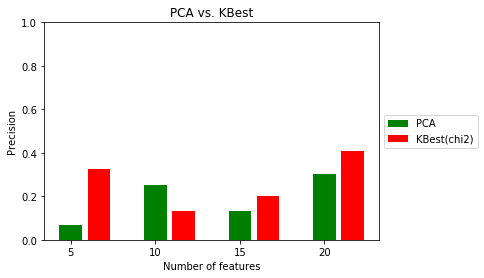

None


In [15]:

classifier = DecisionTreeClassifier(splitter='random', random_state=42)

# print (GridSearch (classifier,'recall',  'Accuracy'))
print (GridSearch (classifier,'recall',  'Recall'))
print (GridSearch (classifier,'precision', 'Precision'))

## Tune the Classifier 

In [37]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. 

#Creat the pipeline
pipe = Pipeline([
    ('reduce_dim', SelectKBest(chi2)),
    ('clf',DecisionTreeClassifier(splitter='best', random_state=42))
])
param_grid = [
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': [5,10,15,20],
        'clf__criterion':['gini', 'entropy'],
        'clf__class_weight':[None, 'balanced']#,
#         'clf__min_samples_split' : [2,3,4,5]
    },
]

#gridsearch
grid = GridSearchCV(clf, cv=5, param_grid=param_grid_DT)
clf = grid.fit(scaled_feature_train, labels_train)
clf = grid.best_estimator_

#print the selected features:
mask = (select.get_support())
new_features = [] 
for bool, feature in zip(mask, features_list):
    if bool:
        new_features.append(feature)
print new_features

#evaluation
labels_predictions = grid.predict(scaled_feature_test)
gbe = grid.best_estimator_
print ("Best parameters are: ", gbe)
pred = clf.predict(scaled_feature_test)
acc= accuracy_score(pred, labels_test)
print ("Accuracy is:",acc)
print ( "Recall is:",  metrics.recall_score(labels_test, pred))
print ( "Precision is:", metrics.precision_score(labels_test, pred))


ValueError: Invalid parameter min_samples_split for estimator GridSearchCV. Check the list of available parameters with `estimator.get_params().keys()`.

## GridSearchCV

In [19]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
features_list_f = ['poi', 'salary', 'total_payments', 'loan_advances', 
                   'restricted_stock_deferred', 'restricted_stock_deferred', 
                   'deferred_income', 'total_stock_value', 'expenses', 
                   'exercised_stock_options', 'other', 'long_term_incentive', 
                   'restricted_stock', 'director_fees', 'to_messages', 
                   'from_poi_to_this_person', 'from_poi_to_this_person_Percent', 
                   'from_messages', 'from_this_person_to_poi', 
                   'from_this_person_to_poi_percent']
dump_classifier_and_data(clf, my_dataset, features_list)

In [21]:
from tester import dump_classifier_and_data, test_classifier
test_classifier(clf, my_dataset, features_list)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': [2, 3, 4, 5], 'criterion': ['gini', 'entropy'], 'class_weight': [None, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
	Accuracy: 0.79153	Precision: 0.20513	Recall: 0.19600	F1: 0.20046	F2: 0.19776
	Total predictions: 15000	True positives:  392	False positives: 1519	False negatives: 1608	True negatives: 11481

